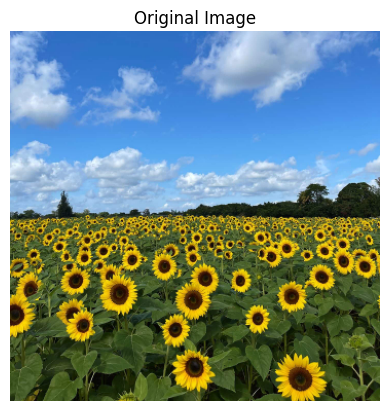

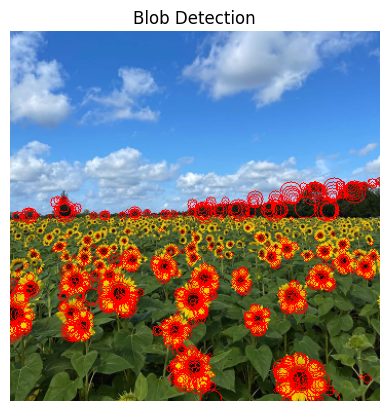

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img = cv.imread('the_berry_farms_sunflower_field.jpeg',cv.IMREAD_REDUCED_COLOR_4)
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)

#plot image
plt.imshow(img_RGB)
plt.title('Original Image')
plt.axis('off')
plt.show()

# define log kernel
def log_kernel(sigma, size):
    if size % 2 == 0:
        size += 1
    sigma2 = sigma ** 2
    idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)
    x_idx, y_idx = np.meshgrid(idx_range, idx_range)
    tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)
    kernel = np.exp(tmp_cal)
    kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0
    k_sum = np.sum(kernel)
    if k_sum != 0:
        kernel /= np.sum(kernel)
    tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)
    kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2)
    return kernel


# blob detection
def detect_blobs(img, sigma_scales, threshold):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    cv.normalize(gray, gray, 1, 0, cv.NORM_MINMAX)

    sigma0 = np.sqrt(2)
    k = np.sqrt(2)
    num_scales = sigma_scale
    sigmas = sigma0 * np.power(k, np.arange(num_scales))
    sigmas = [num_scales]*num_scales
    
    
    # apply LoG kernel filtering with scaled kernel size and sigma
    img_stack = None
    for i in range(num_scales):
        size = int(2 * np.ceil(4 * sigmas[i]) + 1)
        # with Laplacian response normalization
        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2)
        filtered = cv.filter2D(gray, cv.CV_32F, kernel)
        filtered = pow(filtered, 2)
        if i == 0:
            img_stack = filtered
        else:
            img_stack = np.dstack((img_stack, filtered))

    # Maximum response extraction
    scale_space = None
    for i in range(num_scales):
        filtered = cv.dilate(img_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT)
        if i == 0:
            scale_space = filtered
        else:
            scale_space = np.dstack((scale_space, filtered))
    max_stack = np.amax(scale_space, axis=2)
    max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)
    max_stack = np.multiply((max_stack == scale_space), scale_space)

    radius_vec = None
    x_vec = None
    y_vec = None
    for i in range(num_scales):
        radius = np.sqrt(2) * sigmas[i]
        threshold = threshold
        # filter out redundant response
        valid = (max_stack[:, :, i] == img_stack[:, :, i]) * img_stack[:, :, i]
        valid[valid <= threshold] = 0
        (x, y) = np.nonzero(valid)
        if i == 1:
            x_vec = x
            y_vec = y
            radius_vec = np.repeat(radius, np.size(x))
        else:
            x_vec = np.concatenate((x_vec, x), axis=None)
            y_vec = np.concatenate((y_vec, y), axis=None)
            tmp_vec = np.repeat(radius, np.size(x))
            radius_vec = np.concatenate((radius_vec, tmp_vec), axis=None)

    return x_vec, y_vec, radius_vec



img = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
x_all = []
y_all = []
radii_all = []

for sigma_scale in range(2, 9):
    x_coords, y_coords, radii = detect_blobs(img, sigma_scale, 0.03)
    x_all.append(x_coords)
    y_all.append(y_coords)
    radii_all.append(radii)

x_all = np.concatenate(x_all, axis=None)
y_all = np.concatenate(y_all, axis=None)
radii_all = np.concatenate(radii_all, axis=None)

output_img = img.copy()
for i in range(int(len(x_all))):
    cv.circle(output_img, (y_all[i], x_all[i]), int(radii_all[i]), (0, 0, 255), 1)

plt.imshow(cv.cvtColor(output_img, cv.COLOR_BGR2RGB))
plt.title("Blob Detection")
plt.axis('off')
plt.show()


(-0.5, 10.5, 10.5, -0.5)

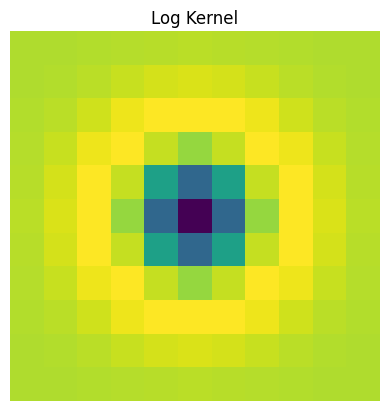

In [11]:
#plot the Log kernel

kernel = log_kernel(1.5, 10)
plt.imshow(kernel)
plt.title("Log Kernel")
plt.axis('off')
